In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer


In [3]:
# Read the CSV file into a DataFrame
customers = pd.read_csv('/content/drive/MyDrive/Zeotap/Customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Zeotap/Products.csv')
transactions= pd.read_csv('/content/drive/MyDrive/Zeotap/Transactions.csv')

We might consider using 2 clusters as the optimal number here, since it has the best Silhouette Score, though it’s not a huge difference compared to 6, 7, or 8 clusters. The DB Index suggests that 2 clusters may also give a better balance between compactness and separation of clusters.

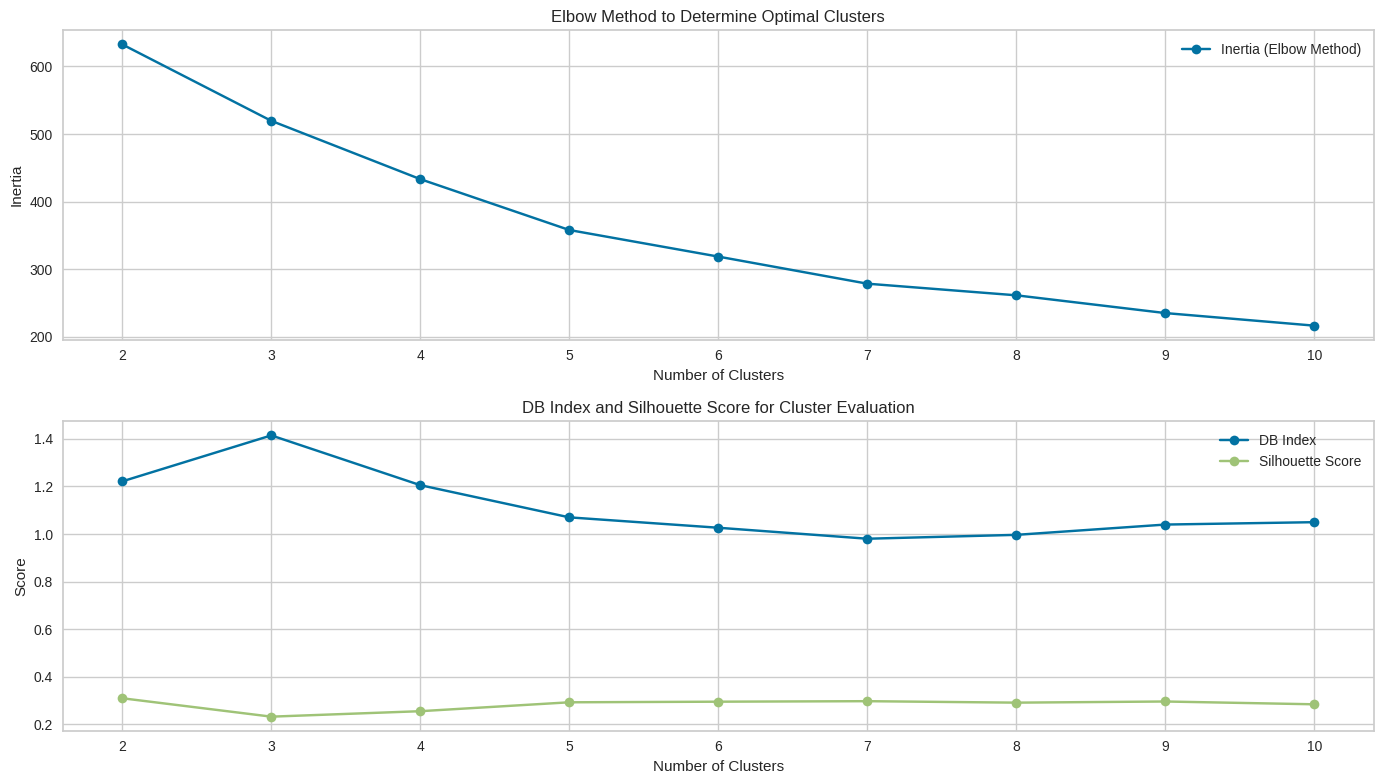

Optimal number of clusters based on Silhouette Score: 2


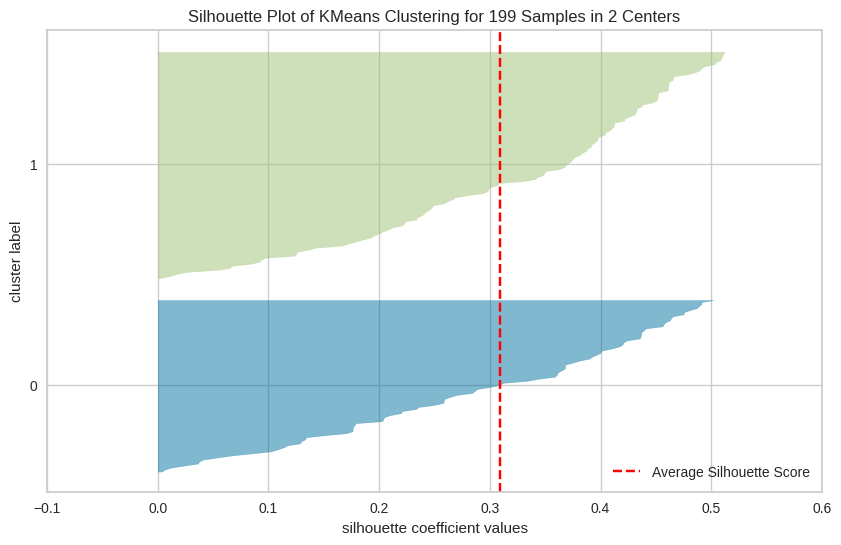

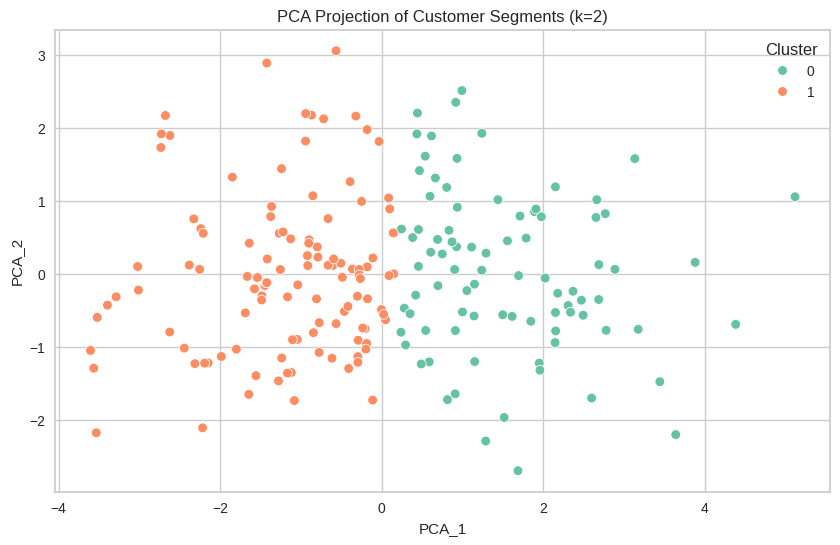

In [7]:


# Function to compute Davies-Bouldin Index and Silhouette Score
def evaluate_clusters(k, customer_data_scaled):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customer_data_scaled)

    db_index = davies_bouldin_score(customer_data_scaled, labels)
    silhouette_avg = silhouette_score(customer_data_scaled, labels)

    return db_index, silhouette_avg

# Trying different cluster numbers and evaluating metrics
cluster_range = range(2, 11)  # Number of clusters from 2 to 10
metrics = []
inertia = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customer_data_scaled)
    db_index, silhouette_avg = evaluate_clusters(k, customer_data_scaled)

    inertia.append(kmeans.inertia_)  # Sum of squared distances to cluster centers
    metrics.append({'Cluster Count': k, 'DB Index': db_index, 'Silhouette Score': silhouette_avg})

# Create a DataFrame to store metrics
metrics_df = pd.DataFrame(metrics)

# Plotting Elbow Method, DB Index, and Silhouette Score
plt.figure(figsize=(14, 8))

# Elbow Method Plot
plt.subplot(2, 1, 1)
plt.plot(cluster_range, inertia, marker='o', label='Inertia (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.legend()

# DB Index and Silhouette Score Plot
plt.subplot(2, 1, 2)
plt.plot(metrics_df['Cluster Count'], metrics_df['DB Index'], label='DB Index', marker='o')
plt.plot(metrics_df['Cluster Count'], metrics_df['Silhouette Score'], label='Silhouette Score', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('DB Index and Silhouette Score for Cluster Evaluation')
plt.legend()

plt.tight_layout()
plt.show()

# Silhouette Visual Analysis for Optimal Clusters
optimal_k = metrics_df.loc[metrics_df['Silhouette Score'].idxmax(), 'Cluster Count']
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

plt.figure(figsize=(10, 6))
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(customer_data_scaled)
visualizer.show()

# PCA Projection and Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(customer_data_scaled)
customer_data['PCA_1'] = principal_components[:, 0]
customer_data['PCA_2'] = principal_components[:, 1]

# Fitting KMeans with Optimal Cluster Count
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Scatterplot for PCA Projection
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Cluster', data=customer_data, palette='Set2')
plt.title(f'PCA Projection of Customer Segments (k={optimal_k})')
plt.show()


Davies-Bouldin Index: 1.2214693034478712


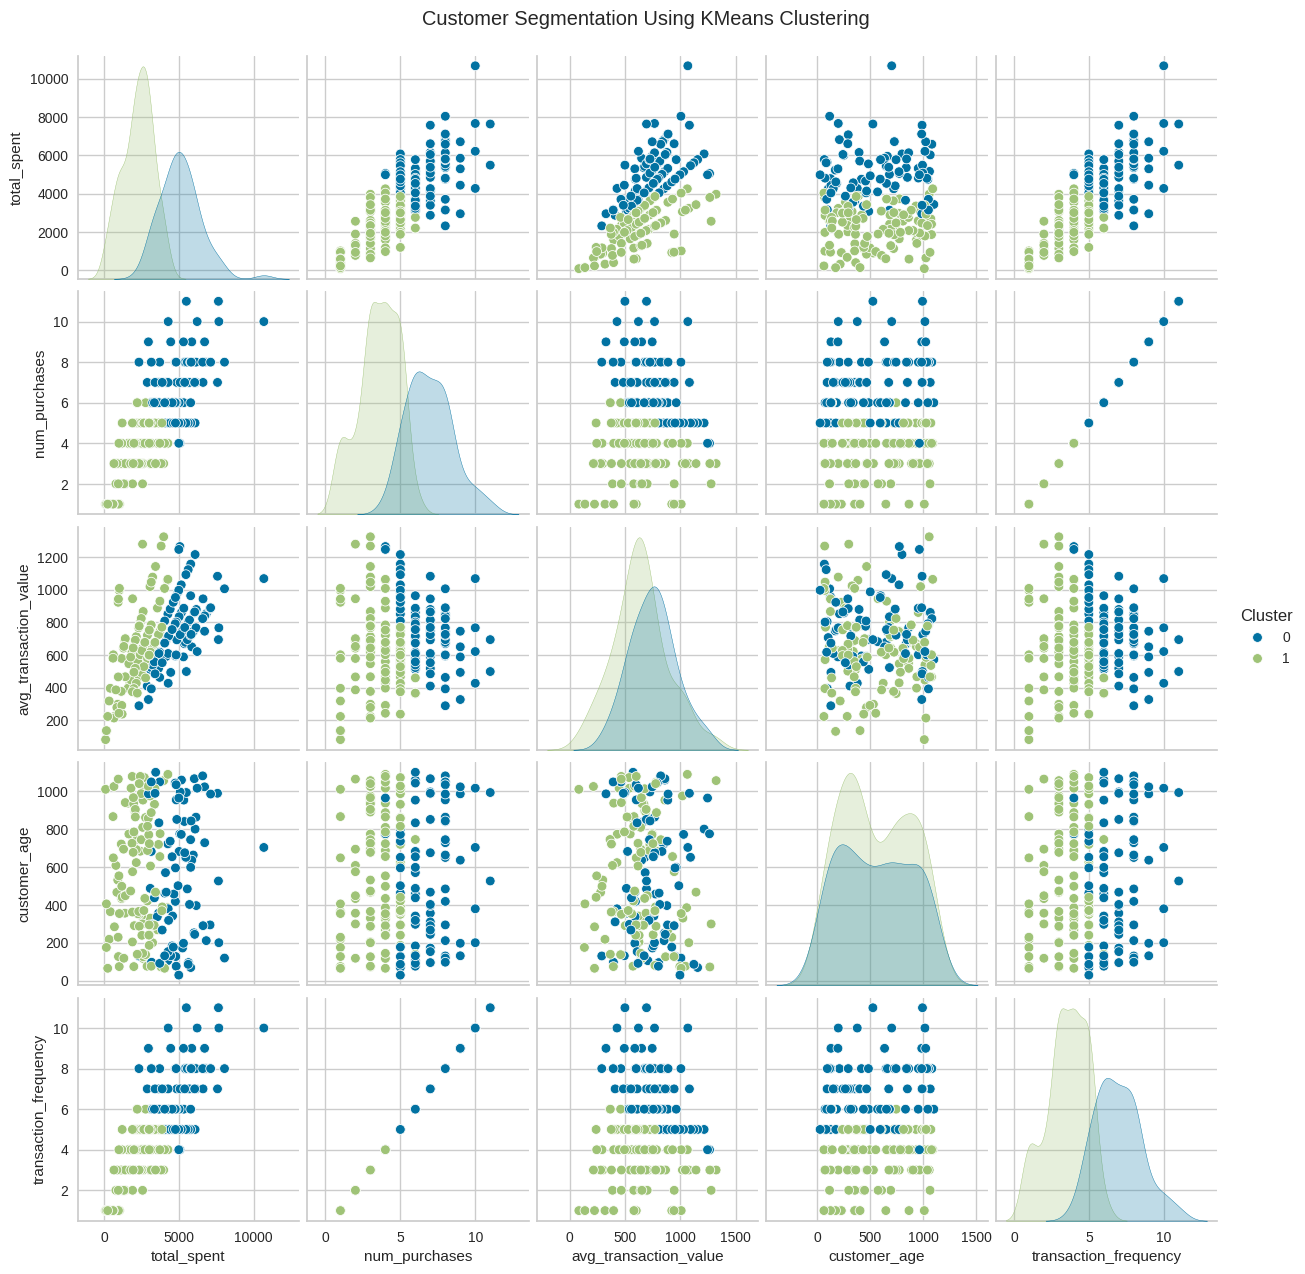

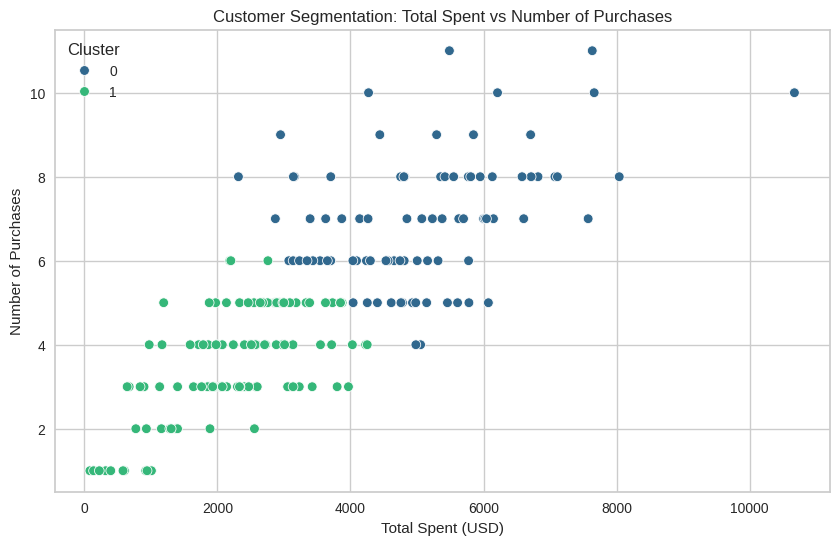

In [8]:
# Merging customers and transactions datasets
data = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Feature engineering: Aggregating transactions per customer
customer_data = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_purchases=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    customer_age=('SignupDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x).min()).days),
    transaction_frequency=('TransactionDate', lambda x: x.nunique())
).reset_index()

# Standardizing the features
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['total_spent', 'num_purchases', 'avg_transaction_value', 'customer_age', 'transaction_frequency']])

# Clustering using KMeans (Number of clusters can be tuned between 2 and 10)
kmeans = KMeans(n_clusters=2, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Calculate the Davies-Bouldin index
db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualizing clusters using a pair plot
sns.pairplot(customer_data, hue='Cluster', vars=['total_spent', 'num_purchases', 'avg_transaction_value', 'customer_age', 'transaction_frequency'])
plt.suptitle('Customer Segmentation Using KMeans Clustering', y=1.02)
plt.show()

# Visualize the clusters using a 2D scatter plot (e.g., total_spent vs num_purchases)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_spent', y='num_purchases', hue='Cluster', data=customer_data, palette='viridis')
plt.title('Customer Segmentation: Total Spent vs Number of Purchases')
plt.xlabel('Total Spent (USD)')
plt.ylabel('Number of Purchases')
plt.legend(title='Cluster')
plt.show()
